Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import math
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

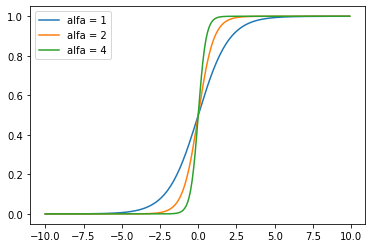

In [3]:
def sigm(x,alfa):
    return 1/(1+np.exp(-alfa*x))

# Na predavanjima prikazan graf od -10 do 10 pa sam i ja stavila to ograničenje
xlist=list(np.arange(-10,10,0.1))

for alfa in [1,2,4]:
    ylist = list(sigm(y,alfa) for y in xlist)
    plt.plot(xlist, ylist,label=f'alfa = {alfa}')
plt.legend()
plt.show()


**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [4]:
from numpy import linalg

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    N = len(X)
    n = len(X[0])
    w=np.zeros(n+1)
    W_matrix=[]
    Errors =[]
    Phi=PolynomialFeatures(1).fit_transform(X)

    for iter in range(0,max_iter):
        delta_w=np.array([0] * (n+1))
        delta_w = delta_w.astype('float32')

        for i in range(0,N):
            h = lr_h(Phi[i],w)
            delta_w-=np.dot((h-y[i]),Phi[i])

        w[0] = w[0] + eta*delta_w[0]
        w[1:] = w[1:]*(1-eta*alpha)+eta*delta_w[1:]

        W_matrix.append(w.copy())

        error=cross_entropy_error(X,y,w)

        if (iter ==0 and abs(error) < epsilon) or (iter != 0 and abs(Errors[-1]-error) < epsilon):
            break

        Errors.append(error)

    if trace:
        return w,W_matrix

    else:
        return w

def lr_h(x,w):
    return sigm(x.dot(w),1)

def cross_entropy_error(X,y,w,alpha=0):
    N = len(X)
    suma=0
    Phi=PolynomialFeatures(1).fit_transform(X)
    for i in range(0,N):
        suma+=-y[i]*np.log(lr_h(Phi[i],w))-(1-y[i])*np.log(1-lr_h(Phi[i],w))
    return 1 / N * suma + alpha/2 * w.T@w


### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [5]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

w = [ 4.45449454 -1.71089241  0.68413507]
Pogreška unakrsne entropije = 0.13521872741132307


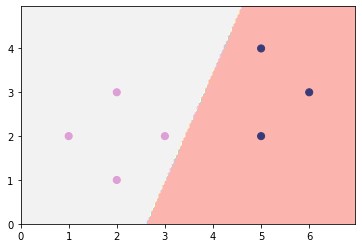

In [6]:
w=lr_train(seven_X,seven_y)
print(f'w = {w}')


error=cross_entropy_error(seven_X,seven_y,w)
print(f'Pogreška unakrsne entropije = {error}')

plot_2d_clf_problem(seven_X,seven_y,lambda x:lr_h(np.insert(x,0,1),w)>=0.5)

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [7]:
from sklearn.metrics import zero_one_loss

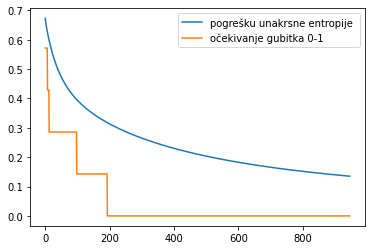

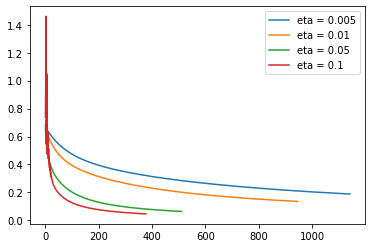

In [8]:
def predict(Phi,w):
    predicted=lr_h(Phi,w)
    predicted_01=[]
    for p in predicted:
        if p >= 0.5:
            predicted_01.append(1)
        else:
            predicted_01.append(0)
    return predicted_01

last_w,W_matrix=lr_train(seven_X,seven_y,trace=True)
iterations=len(W_matrix)
Phi=PolynomialFeatures(1).fit_transform(seven_X)
plt.plot(range(0,iterations),[cross_entropy_error(seven_X,seven_y,w) for w in W_matrix],label=f'pogrešku unakrsne entropije ')
plt.plot(range(0,iterations),
         [zero_one_loss(seven_y,predict(Phi,w)) for w in W_matrix],
         label=f'očekivanje gubitka 0-1 ')
plt.legend()
plt.show()

for eta in [0.005,0.01,0.05,0.1]:
    last_w,W_matrix=lr_train(seven_X,seven_y,eta,trace=True)
    iterations=len(W_matrix)
    plt.plot(range(0,iterations),[cross_entropy_error(seven_X,seven_y,w) for w in W_matrix],label=f'eta = {eta}')
    plt.legend()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

Predicted values: [1 1 1 1 0 0 0]
Real values: [1 1 1 1 0 0 0]
w=[5.33129609][[-1.18244419 -0.30251926]]


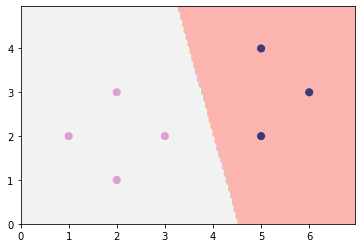

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(seven_X, seven_y)
print(f'Predicted values: {model.predict(seven_X)}')
print(f'Real values: {seven_y}')

print(f'w={model.intercept_}{model.coef_}')
plot_2d_clf_problem(seven_X,seven_y,lambda x:model.predict(x))

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [10]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

w = [ 4.23566418 -1.66592903  0.6994037 ]
Pogreška unakrsne entropije = 0.12597001374533123


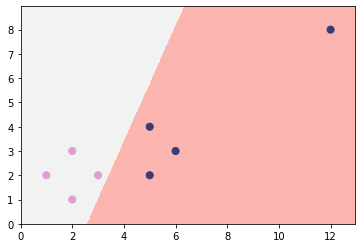

w=[5.33162957][[-1.18249684 -0.30258673]]


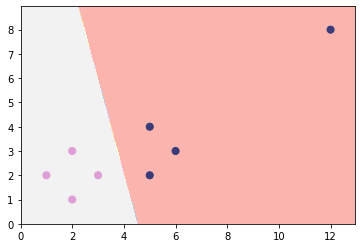

In [11]:
w=lr_train(outlier_X,outlier_y)
print(f'w = {w}')


error=cross_entropy_error(outlier_X,outlier_y,w)
print(f'Pogreška unakrsne entropije = {error}')

plot_2d_clf_problem(outlier_X,outlier_y,lambda x:lr_h(np.insert(x,0,1),w)>=0.5)
plt.show()

model = LogisticRegression().fit(outlier_X, outlier_y)
print(f'w={model.intercept_}{model.coef_}')
plot_2d_clf_problem(outlier_X,outlier_y,lambda x:model.predict(x))

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

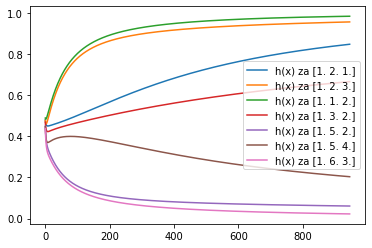

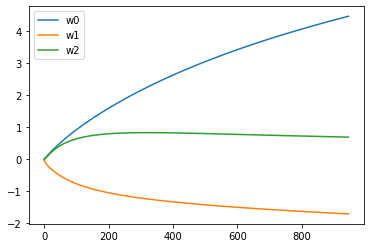

In [12]:
w,W_matrix=lr_train(seven_X,seven_y,trace=True)
iterations=len(W_matrix)
Phi=PolynomialFeatures(1).fit_transform(seven_X)

for x in Phi:
    plt.plot(range(0,iterations),[lr_h(x,w) for w in W_matrix],label=f'h(x) za {x}')
    plt.legend()
plt.show()

plt.plot(range(0,iterations),[w[0] for w in W_matrix],label=f'w0')
plt.plot(range(0,iterations),[w[1] for w in W_matrix],label=f'w1')
plt.plot(range(0,iterations),[w[2] for w in W_matrix],label=f'w2')
plt.legend()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [13]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

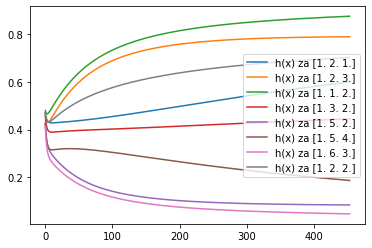

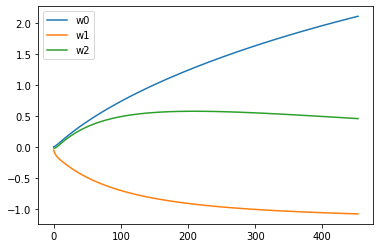

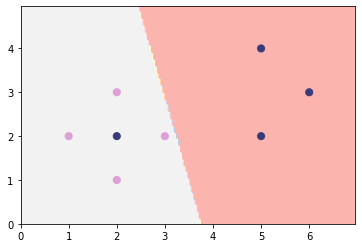

In [19]:
w,W_matrix=lr_train(unsep_X,unsep_y,trace=True)
iterations=len(W_matrix)
Phi=PolynomialFeatures(1).fit_transform(unsep_X)

for x in Phi:
    plt.plot(range(0,iterations),[lr_h(x,w) for w in W_matrix],label=f'h(x) za {x}')
    plt.legend()
plt.show()

plt.plot(range(0,iterations),[w[0] for w in W_matrix],label=f'w0')
plt.plot(range(0,iterations),[w[1] for w in W_matrix],label=f'w1')
plt.plot(range(0,iterations),[w[2] for w in W_matrix],label=f'w2')
plt.legend()
plt.show()
model = LogisticRegression().fit(unsep_X, unsep_y)
plot_2d_clf_problem(unsep_X,unsep_y,lambda x:model.predict(x))

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [15]:
from numpy.linalg import norm

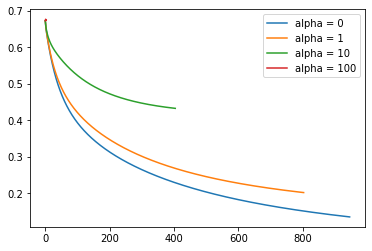

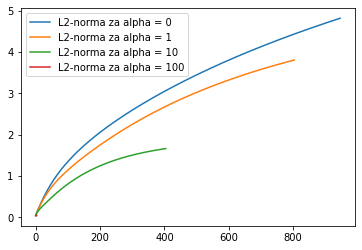

In [16]:
for alfa in [0,1,10,100]:
    last_w,W_matrix=lr_train(seven_X,seven_y,alpha=alfa,trace=True)
    iterations=len(W_matrix)
    plt.plot(range(0,iterations),[cross_entropy_error(seven_X,seven_y,w) for w in W_matrix],label=f'alpha = {alfa}')
    plt.legend()
plt.show()

for alfa in [0,1,10,100]:
    last_w,W_matrix=lr_train(seven_X,seven_y,alpha=alfa,trace=True)
    iterations=len(W_matrix)
    plt.plot(range(0,iterations),[np.sqrt(np.sum(w*w)) for w in W_matrix],label=f'L2-norma za alpha = {alfa}')
    plt.legend()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [17]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

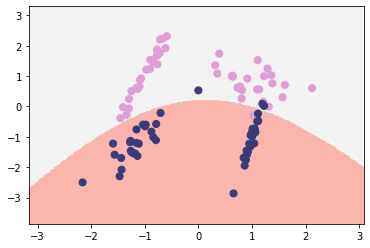

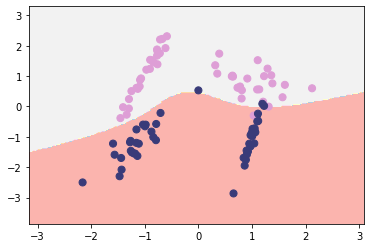

In [18]:
from sklearn.datasets import make_classification

X_100, Y_100 = make_classification(n_informative=2,n_clusters_per_class=2,n_features=2,n_redundant=0,n_classes=2)

# print(X_100)
# print(Y_100)

for d in [2,3]:
    poly = PolynomialFeatures(d)
    Phi_X=poly.fit_transform(X_100)
    model = LogisticRegression().fit(Phi_X,Y_100)
    plot1 = plt.figure(d)
    plot_2d_clf_problem(X_100,Y_100,lambda x: model.predict(poly.fit_transform(x)))



**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?